# Image processing

## Image dilation

Image dilation and erosion form the basic operations of morphological image processing:

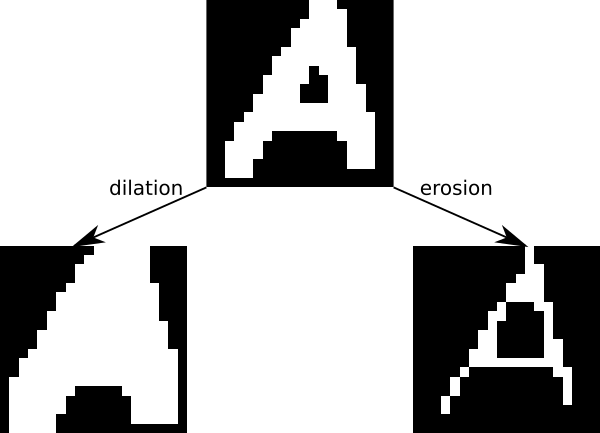

Dilation of binary images can be understood as processing the binary image using a mask in the following manner:

1. The mask is positioned with its reference-point (usually the mask center) at each pixel position of the image.
2. For each position, we check, whether pixels within the mask overlap with the set of foreground pixels of the binary image.
3. If this is the case, then the respective pixel is set 1: it is part of the dilated image. If not, it is set 0.

Since the resulting value of a pixel in the final image depends only on pixel-values in its neighborhood (as defined by the mask), this operation can be run in parallel for each pixel.

Together with image erosion we can perform a closing-operation, which is a common operation in image segmentation tasks to remove artifacts (e.g. holes) in thresholded images:

|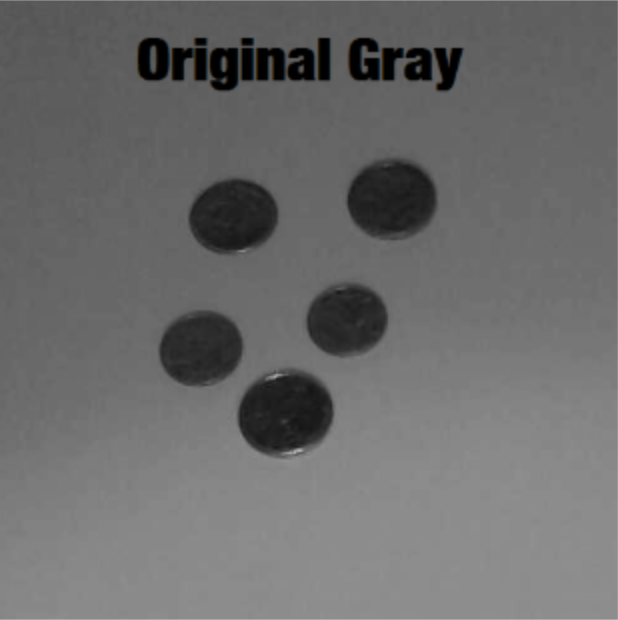| 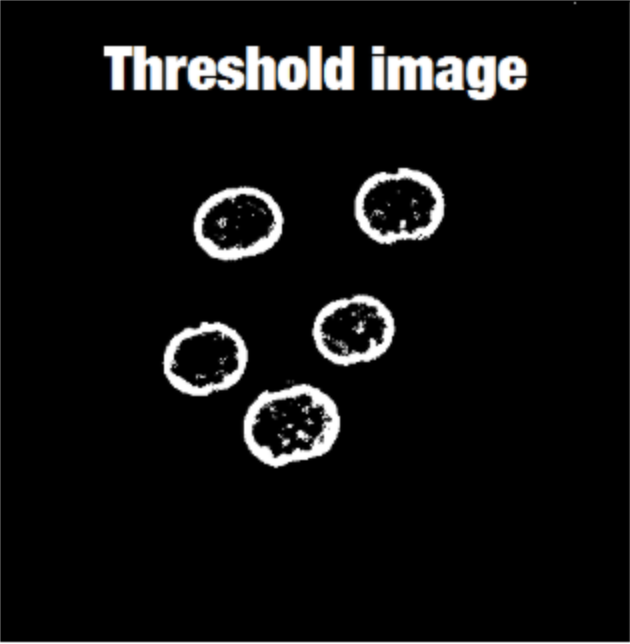 | 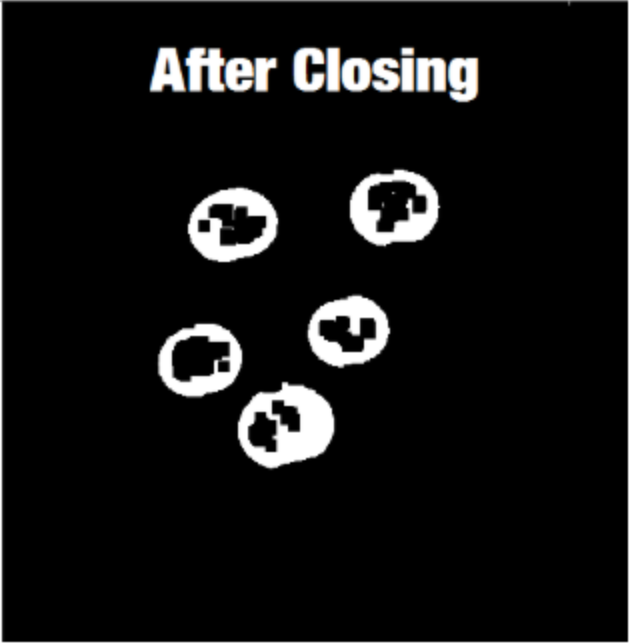 |

Implementation of image dilation:

* In the following we assume that the mask is composed of a centered 3x3 pixel area.
* Dilation can then be implemented as two for-loops running over the neighborhood of each pixel.
* In the loops, we determine tha maximum value in that neighborhood and set the repective pixel to that value.

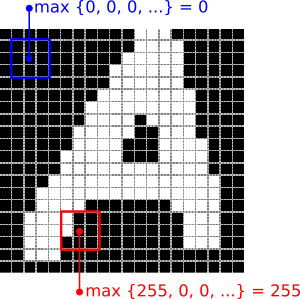


 Image credits: [1](https://towardsdatascience.com/get-started-with-gpu-image-processing-15e34b787480), [2](https://blog.christianperone.com/2014/06/simple-and-effective-coin-segmentation-using-python-and-opencv/)


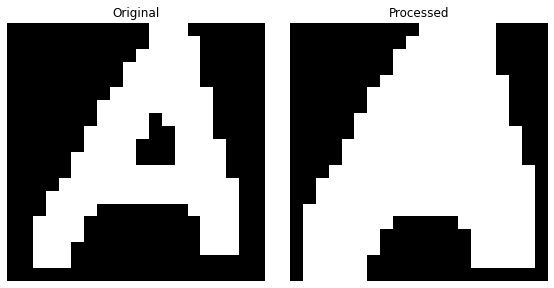

In [30]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from skimage import io

image = io.imread("../codes/image_processing/image_dilation/letter_image.png")
image_shape = image.shape[0]

image_dilated = np.zeros_like(image)

@cuda.jit
def dilate(image, result):
    image_height, image_width = image.shape

    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

#     if 0 < row < image_height - 1:
#         if 0 < col < image_width - 1:
#             extreme_value = 0
#             for i in range(-1, 2):
#                 for j in range(-1, 2):
#                     pixel_value = image[row + i, col + j]
#                     extreme_value = max(pixel_value, extreme_value)
#             result[row, col] = extreme_value
    extreme_value = 0
    for i in range(-1, 2):
        for j in range(-1, 2):
            pixel_value = image[row + i, col + j]
            extreme_value = max(pixel_value, extreme_value)
    result[row, col] = extreme_value

threads_per_block = (16, 16)
blocks_per_grid_x = int(np.ceil(image_shape / threads_per_block[0]))
blocks_per_grid_y = int(np.ceil(image_shape / threads_per_block[1]))
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

# call dilation kernel
dilate[blocks_per_grid, threads_per_block](image, image_dilated)

# keep only valid range
# image_dilated = image_dilated[1:-1, 1:-1]

# show images
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
axes[0].imshow(image, cmap=plt.cm.gray)
axes[0].set_title('Original')
axes[1].imshow(image_dilated, cmap=plt.cm.gray)
axes[1].set_title('Processed')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

## Image convolution for edge detection

Convolution is a central operation in image processing, where the image is filtered with a kernel (also called filter or convolution matrix).
Depending on the kernel that is used, we can e.g. blur or sharpen the images or detect edges.

In the following we use the sobel-v filter to detect vertical edges in an image. The operation is defined as

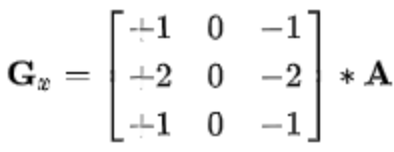,

where the Sobel filter S<sub>x</sub> in x-direction is convolved with the image A resulting in the approximate gradient G<sub>x</sub> in x-direction. Moreover, one can calculate the gradient in vertical direction as well

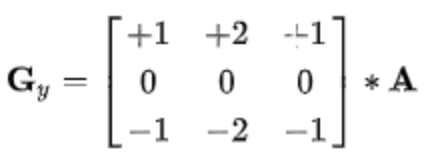

and obtain the magnitude of the gradient at each pixel as:

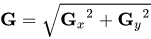

Generally, the discrete convolution is computed as

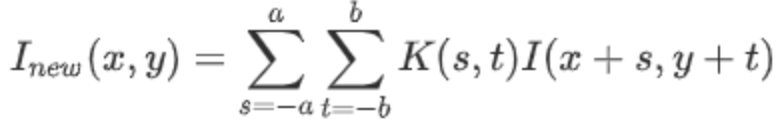,

where K(s,t) is the kernel, I(x,y) is the original and image I<sub>new</sub>(x,y) is the resulting filtered image. In our case, for the Sobel-filter K has shape 3x3.  Each pixel in I<sub>new</sub>(x,y) is the result of the sum over all neighborhood-pixels multiplied (weighted) with its corresponding filter value.

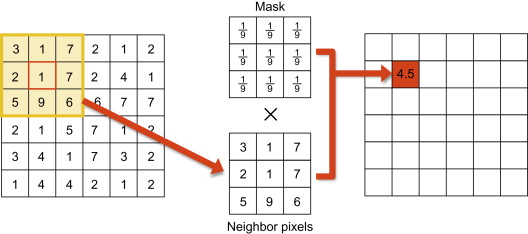

Since the final pixel value in depends only on its neighborhood and the (fixed) values in the kernel, this operation can be run in parallel for each pixel.

Sources: [1](https://www.sciencedirect.com/topics/computer-science/linear-convolution)

### Scikit-Image version

min pixel value: -0.87254906
max pixel value: 0.9196078


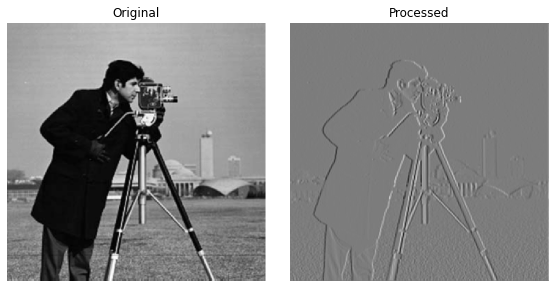

In [31]:
import numpy as np
import matplotlib.pyplot as plt
from skimage import filters, io

# read image and normalize
image = io.imread("../codes/image_processing/sobel_v_convolution/photographer.png").astype(np.float32)
# image = io.imread("photographer.png").astype(np.float32)
image -= np.min(image)
image /= np.max(image)

# filter vertical edges with sobel_v
edges_sobel_v = filters.sobel_v(image)

# print min- and max-values for comparison with reference implementation
print("min pixel value: " + str(np.min(edges_sobel_v)))
print("max pixel value: " + str(np.max(edges_sobel_v)))

# show images
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
axes[0].imshow(image, cmap=plt.cm.gray)
axes[0].set_title('Original')
axes[1].imshow(edges_sobel_v, cmap=plt.cm.gray)
axes[1].set_title('Processed')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()


### CUDA implementation

min pixel value: -0.87254906
max pixel value: 0.9196078


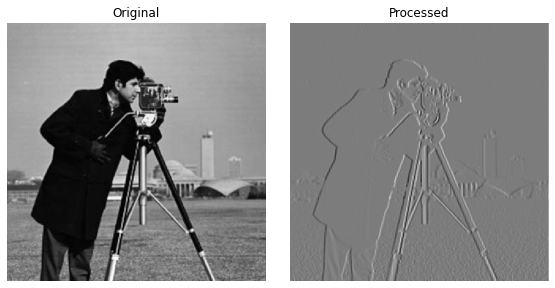

In [32]:
import numpy as np
import matplotlib.pyplot as plt
from numba import cuda
from skimage import io

# read image and normalize
# image = io.imread('photographer.png').astype(np.float32)
image = io.imread("../codes/image_processing/sobel_v_convolution/photographer.png").astype(np.float32)
image -= np.min(image)
image /= np.max(image)
image_shape = image.shape[0]

# Sobel filter for vertical edges
tmp = np.array([[-1, 0, 1], [-2, 0, 2], [-1, 0, 1]], dtype=np.float32)
sobel_v_filter = (1. / 4) * np.array(tmp, dtype=np.float32)

filter_height, filter_width = sobel_v_filter.shape
filter_height_halved = filter_height // 2
filter_width_halved = filter_width // 2

# get shape of input image, allocate memory for output to which result can be copied to
edges_sobel_v = np.zeros_like(image)


@cuda.jit
def filter2d(image, filt, result):
    image_height, image_width = image.shape
    filter_height, filter_width = filt.shape
    filter_height_halved = filter_height // 2
    filter_width_halved = filter_width // 2

    row = cuda.blockIdx.y * cuda.blockDim.y + cuda.threadIdx.y
    col = cuda.blockIdx.x * cuda.blockDim.x + cuda.threadIdx.x

    if (row > filter_height_halved and row < image_height - filter_height_halved):
        if (col > filter_width_halved and col < image_width - filter_width_halved):
            sum = 0.0
            for conv_index_y in range(-filter_height_halved, filter_height_halved + 1):
                for conv_index_x in range(-filter_width_halved, filter_width_halved + 1):
                    kernelCoord = filter_height_halved + conv_index_y, filter_width_halved + conv_index_x
                    imageCoord = row + conv_index_y, col + conv_index_x
                    sum += filt[kernelCoord] * image[imageCoord]
            result[row, col] = sum


threads_per_block = (16, 16)
blocks_per_grid_x = int(np.ceil(image_shape / threads_per_block[0]))
blocks_per_grid_y = int(np.ceil(image_shape / threads_per_block[1]))
blocks_per_grid = (blocks_per_grid_x, blocks_per_grid_y)

# filter vertical edges with sobel_v_filter
filter2d[blocks_per_grid, threads_per_block](image, sobel_v_filter, edges_sobel_v)

# ignore edges, which are not a valid result
edges_sobel_v = edges_sobel_v[filter_height_halved:-filter_height_halved,
                filter_width_halved:-filter_width_halved]

# print min- and max-values for comparison with reference implementation
print("min pixel value: " + str(np.min(edges_sobel_v)))
print("max pixel value: " + str(np.max(edges_sobel_v)))

# show images
fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
axes[0].imshow(image, cmap=plt.cm.gray)
axes[0].set_title('Original')
axes[1].imshow(edges_sobel_v, cmap=plt.cm.gray)
axes[1].set_title('Processed')
for ax in axes:
    ax.axis('off')
plt.tight_layout()
plt.show()

## Image rotation with hardware accelerated pixel interpolation

Modern GPUs have dedicate hardware for image sampling. These are able to interpolate pixel values and handle out-of-bound sampling transparently in hardware.
While interpolation is usually restricted to linear and nearest-neighbor interpolation, hardware interpolation can significantly accelerate algorithms that depend on massive sampling of image-data.

Here we will rotate an image using the hardware sampler. Since Numba-CUDA does not implement this feature, we will use the Open Compute Language (OpenCL). OpenCL open,  vendor-agnostic standard similar to CUDA.

ToDo:
* Explain separate kernel C-code.
* Explain the differing naming convention of OpenCL vs Cuda, where relevant.

In [33]:
ocl_kernel = """
/**
 * Rotate image using normalized coordinates for the sampler.
 * Normalized sample coordinates are needed to be able to use repeating
 * boundaries (i.e. for using CLK_ADDRESS_REPEAT).
 */
__kernel void img_rotate(
    sampler_t sampler,
    __read_only image2d_t src_data,
    __write_only image2d_t dest_data,
    double sinTheta,
    double cosTheta)
    {
        // work-item gets its index within index space
        const int ix = get_global_id(0);
        const int iy = get_global_id(1);

        // calculate normalized coordinates from work-item index (ix,iy)
        float imageWidth = get_image_width(src_data);
        float imageHeight = get_image_height(src_data);
        float xCenter = .5f;
        float yCenter = .5f;
        float xOffset = ix/imageWidth - xCenter;
        float yOffset = iy/imageHeight - yCenter;
        float xpos = (xOffset*cosTheta + yOffset*sinTheta + xCenter);
        float ypos = (yOffset*cosTheta - xOffset*sinTheta + yCenter);

        // resample image
        const float pxVal = read_imagef(src_data, sampler, (float2)(xpos, ypos)).s0;

        // write to output
        write_imagef(dest_data, (int2)(ix, iy), (float4)(pxVal, 0.0f, 0.0f, 0.0f));
}
"""

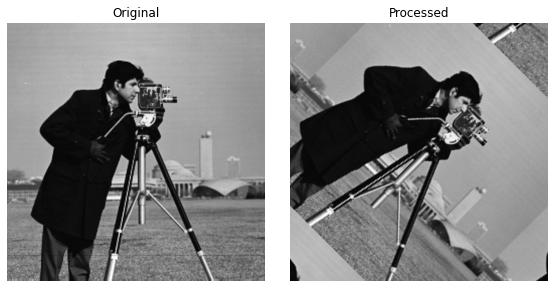

In [34]:
import cv2
import numpy as np
import pyopencl as cl
import matplotlib.pyplot as plt

'''
This is an example of how to define a sampler from PyOpenCL and pass
it to the kernel. We resample the image so that it is rotated.
* We can change sampler properties for out-of-bounds behavior
and interpolation.
* Coordinates must be normalized for the cl.addressing_mode.REPEAT to work.
'''

def main():
    # setup OpenCL
    platforms = cl.get_platforms()  # a platform corresponds to a driver (e.g. AMD, NVidia, Intel)
    platform = platforms[0]  # take first platform
    devices = platform.get_devices(cl.device_type.GPU)  # get GPU devices of selected platform
    device = devices[0]  # take first GPU
    context = cl.Context([device])  # put selected GPU into context object
    queue = cl.CommandQueue(context, device)  # create command queue for selected GPU and context

    # prepare data
#     imgIn = cv2.imread('photographer.png', cv2.IMREAD_GRAYSCALE)
    imgIn = cv2.imread("../codes/image_processing/image_rotation_pyopencl/photographer.png", cv2.IMREAD_GRAYSCALE)

    rotation_angle = np.pi/4
    cos_theta = np.cos(rotation_angle)
    sin_theta = np.sin(rotation_angle)

    # setup sampler
#     sampler = cl.Sampler(context, True, cl.addressing_mode.REPEAT, cl.filter_mode.LINEAR)
    sampler = cl.Sampler(context, True, cl.addressing_mode.REPEAT, cl.filter_mode.NEAREST)

    # get shape of input image, allocate memory for output to which result can be copied to
    shape = imgIn.T.shape
    imgOut = np.empty_like(imgIn)

    # create image buffers which hold images for OpenCL
    imgInBuf = cl.image_from_array(context, ary=imgIn, mode="r", norm_int=True, num_channels=1)
    imgOutBuf = cl.image_from_array(context, ary=imgOut, mode="w", norm_int=True, num_channels=1)

    # load, compile and execute OpenCL program
#     program = cl.Program(context, open('kernel.cl').read()).build()
    program = cl.Program(context, ocl_kernel).build()

    program.img_rotate(queue, shape, None, sampler, imgInBuf, imgOutBuf, np.double(sin_theta), np.double(cos_theta))
    cl.enqueue_copy(queue, imgOut, imgOutBuf, origin=(0, 0), region=shape,
                    is_blocking=True)  # wait until finished copying resulting image back from GPU to CPU

    # write output image
    cv2.imwrite('photographer_rotated.png', imgOut)

#     # show images
#     fig, ax = plt.subplots(1, 2)
#     ax[0].imshow(imgIn, cmap='gray')
#     ax[1].imshow(imgOut, cmap='gray')
#     plt.show()

    # show images
    fig, axes = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(8, 4))
    axes[0].imshow(imgIn, cmap=plt.cm.gray)
    axes[0].set_title('Original')
    axes[1].imshow(imgOut, cmap=plt.cm.gray)
    axes[1].set_title('Processed')
    for ax in axes:
        ax.axis('off')
    plt.tight_layout()
    plt.show()
    
if __name__ == '__main__':
    main()
